In [33]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
RANDOM_SEED = 1

In [4]:
df = pd.read_csv("Housing.csv")

In [5]:
df.head(2)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished


In [6]:
encoded_data = pd.get_dummies(df,columns=['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea','furnishingstatus'])

In [7]:
df_categorical = ['mainroad_no', 'mainroad_yes', 'guestroom_no', 'guestroom_yes','basement_no', 'basement_yes', 'hotwaterheating_no','hotwaterheating_yes', 'airconditioning_no', 'airconditioning_yes','prefarea_no', 'prefarea_yes', 'furnishingstatus_furnished','furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']

In [8]:
encoded_data[df_categorical] = encoded_data[df_categorical].astype(float)

In [9]:
X = encoded_data.drop(['price'],axis=1)
y = encoded_data['price']

In [10]:
X = torch.from_numpy(X.values).type(torch.float)
y = torch.from_numpy(y.values).type(torch.float).unsqueeze(dim=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=RANDOM_SEED)

In [12]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([436, 20]) torch.Size([436, 1]) torch.Size([109, 20]) torch.Size([109, 1])


In [13]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [14]:
class HousingPriceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features=20,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16,out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8,out_features=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer(x)


In [15]:
model = HousingPriceModel().to(device)
#model.state_dict()

In [16]:
# setup loss
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [17]:
# Training 
EPOCHS = 100000
epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(EPOCHS):
    model.train()

    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)

     # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backprop wrt parameters
    loss.backward()

    # 5. step optimizer ( perform gradient descent)
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 1000 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print('Epoch', epoch, 'Training Loss:', loss.item(), 'Test loss:', test_loss.item())


Epoch 0 Training Loss: 4768763.5 Test loss: 4758580.5
Epoch 1000 Training Loss: 1362896.375 Test loss: 1243604.375
Epoch 2000 Training Loss: 1359226.125 Test loss: 1241680.625
Epoch 3000 Training Loss: 1354726.75 Test loss: 1239327.25
Epoch 4000 Training Loss: 1346710.875 Test loss: 1235102.5
Epoch 5000 Training Loss: 1117922.125 Test loss: 1111577.75
Epoch 6000 Training Loss: 825384.5625 Test loss: 979350.0
Epoch 7000 Training Loss: 765766.5 Test loss: 921024.6875
Epoch 8000 Training Loss: 740278.25 Test loss: 891582.0625
Epoch 9000 Training Loss: 728612.0625 Test loss: 878330.0625
Epoch 10000 Training Loss: 721345.375 Test loss: 870083.0
Epoch 11000 Training Loss: 716738.0 Test loss: 864015.6875
Epoch 12000 Training Loss: 713288.3125 Test loss: 860422.0625
Epoch 13000 Training Loss: 711359.5 Test loss: 858217.625
Epoch 14000 Training Loss: 707169.875 Test loss: 857995.0
Epoch 15000 Training Loss: 704468.75 Test loss: 857209.4375
Epoch 16000 Training Loss: 703201.8125 Test loss: 85768

In [18]:
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [19]:
xtrain, xtest, ytrain, ytest = train_test_split(df,df['price'],test_size=0.2, random_state=RANDOM_SEED)

In [20]:
xtest

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
62,7070000,6240,4,2,2,yes,no,no,no,yes,1,no,furnished
247,4550000,8400,4,1,4,yes,no,no,no,no,3,no,unfurnished
142,5600000,10500,4,2,2,yes,no,no,no,no,1,no,semi-furnished
107,6125000,6420,3,1,3,yes,no,yes,no,no,0,yes,unfurnished
483,2940000,6615,3,1,2,yes,no,no,no,no,0,no,semi-furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,4900000,4095,3,1,2,no,yes,yes,no,yes,0,no,semi-furnished
92,6405000,4800,3,2,4,yes,yes,no,no,yes,0,no,furnished
66,6930000,13200,2,1,1,yes,no,yes,yes,no,1,no,furnished
284,4270000,7770,2,1,1,yes,no,no,no,no,1,no,furnished


In [22]:
test_pred = model(X_test)

In [23]:
test_pred

tensor([[5738019.5000],
        [6514206.5000],
        [5564829.5000],
        [5727452.5000],
        [4285425.5000],
        [3428549.5000],
        [2274395.5000],
        [7923336.5000],
        [2926015.5000],
        [4159479.5000],
        [3448561.5000],
        [3494437.2500],
        [4919452.5000],
        [4272703.5000],
        [4521722.5000],
        [7788036.5000],
        [4414543.0000],
        [3758795.0000],
        [6470459.5000],
        [2771050.5000],
        [5022283.0000],
        [4865273.5000],
        [4731299.0000],
        [3653963.7500],
        [4405481.5000],
        [6641086.5000],
        [2865699.0000],
        [6501320.5000],
        [8277214.5000],
        [3711135.5000],
        [7525676.5000],
        [6746125.5000],
        [3494110.5000],
        [4528960.5000],
        [5964589.5000],
        [4470298.5000],
        [5959545.5000],
        [3483647.5000],
        [4869339.0000],
        [5467400.0000],
        [3810659.5000],
        [3162440

In [24]:
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


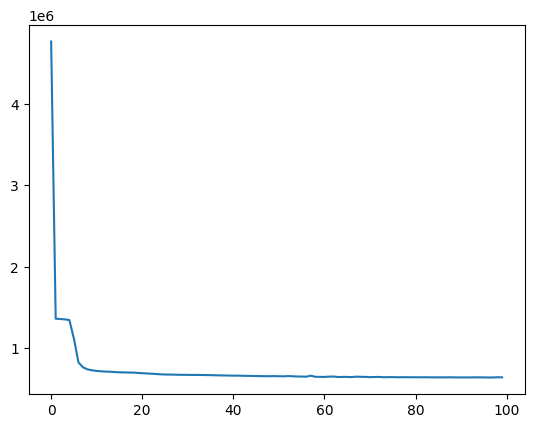

In [38]:
plt.plot([l.item() for l in loss_values])

[4768763.5,
 1362896.375,
 1359226.125,
 1354726.75,
 1346710.875,
 1117922.125,
 825384.5625,
 765766.5,
 740278.25,
 728612.0625,
 721345.375,
 716738.0,
 713288.3125,
 711359.5,
 707169.875,
 704468.75,
 703201.8125,
 701581.625,
 701072.0,
 697084.4375,
 693668.9375,
 689967.0625,
 687289.3125,
 683267.25,
 679806.8125,
 677217.875,
 676545.8125,
 675899.1875,
 673860.375,
 673568.5625,
 672970.625,
 672168.3125,
 672392.75,
 671229.625,
 670401.4375,
 669696.25,
 667801.375,
 666515.6875,
 665412.4375,
 664503.0625,
 663381.375,
 663520.3125,
 662252.5,
 660628.25,
 659721.0625,
 658544.5,
 657657.5,
 656642.5625,
 656212.4375,
 657864.0625,
 655758.0625,
 654909.8125,
 657916.875,
 655820.6875,
 652692.75,
 652230.875,
 650419.875,
 662457.0625,
 649115.125,
 648306.4375,
 647507.4375,
 651291.4375,
 652682.4375,
 646633.3125,
 647440.4375,
 647984.4375,
 645365.6875,
 651255.1875,
 648788.625,
 648151.0625,
 644757.5,
 646520.4375,
 647367.0,
 644014.5,
 644652.25,
 645387.5,
 6